### In this assignment students need to predict whether a person makes over  50K per year or not from classic adult dataset using XGBoost. The  description of the dataset is as follows:


#### Data Set Information:

Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))

Prediction task is to determine whether a person makes over 50K a year.


#### Attribute Information:

##### Listing of attributes:

+ age: continuous.
+ workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
+ fnlwgt: continuous.
+ education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
+ education-num: continuous.
+ marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
+ occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
+ relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
+ race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
+ sex: Female, Male.
+ capital-gain: continuous.
+ capital-loss: continuous.
+ hours-per-week: continuous.
+ native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

### Import Libraries

In [1]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plot 
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,RandomizedSearchCV

### Loading dataset

In [2]:
df_train = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", header = None)
df_test = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test" , skiprows = 1, header = None) 

In [3]:
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',  'marital_status', 'occupation','relationship', 'race', 'sex', 'capital_gain',  'capital_loss', 'hours_per_week', 'native_country', 'wage_class'] 
df_train.columns = col_labels
df_test.columns = col_labels

In [4]:
df_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
df_test.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


### Data Cleaning

Check the training & testing data is any null data present.

In [6]:
train = df_train.copy()
test = df_test.copy()

In [7]:
train.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
wage_class        0
dtype: int64

In [8]:
test.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
wage_class        0
dtype: int64

Converting categorical to numerical data for training & testing dataset

In [9]:
from sklearn.preprocessing import LabelEncoder
lbl_encoder = LabelEncoder()

In [10]:
def convert_categorical_numeric(df):
    cols = ['workclass','education', 'marital_status', 'occupation','relationship','race','sex', 'native_country', 'wage_class']
    for column in cols:
        df[column] = lbl_encoder.fit_transform(df[column])    

In [11]:
convert_categorical_numeric(train)
convert_categorical_numeric(test)

In [12]:
train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


In [13]:
test.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,4,226802,1,7,4,7,3,2,1,0,0,40,38,0
1,38,4,89814,11,9,2,5,0,4,1,0,0,50,38,0
2,28,2,336951,7,12,2,11,0,4,1,0,0,40,38,1
3,44,4,160323,15,10,2,7,0,2,1,7688,0,40,38,1
4,18,0,103497,15,10,4,0,3,4,0,0,0,30,38,0


In [14]:
print(train.shape)
print(test.shape)

(32561, 15)
(16281, 15)


From the above test and train datset the categorical values are changed to numerical one.

 ### Exploratory Data Analysis

### For Training dataset

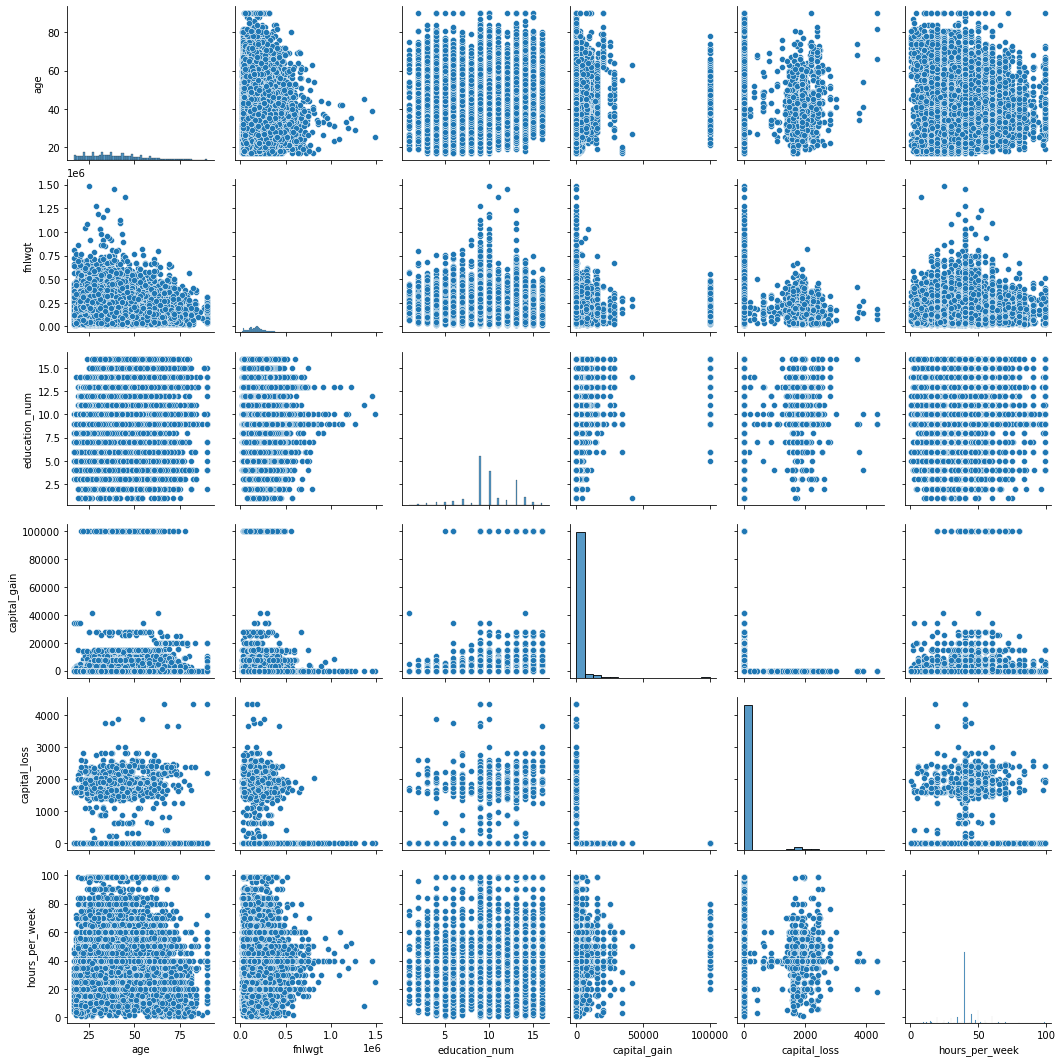

In [15]:
sns.pairplot(df_train)

In [16]:
group_by_wage_class_sex = df_train.groupby(['wage_class','sex'])['sex'].count().to_frame(name = 'Total_count').reset_index()

In [17]:
group_by_wage_class_count = group_by_wage_class_sex.groupby(['wage_class'])['Total_count'].sum()

([<matplotlib.patches.Wedge at 0x25746e05a00>,
 [Text(-0.7999477838977984, 0.7550387692277803, '<=50K'),
  Text(0.7999477838977981, -0.7550387692277808, '>50K')],
 [Text(-0.43633515485334456, 0.4118393286696983, '75.92%'),
  Text(0.43633515485334434, -0.4118393286696986, '24.08%')])

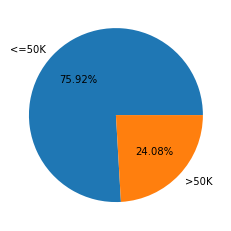

In [18]:
plot.pie(group_by_wage_class_count, autopct='%1.2f%%', labels=['<=50K','>50K'])

From the datatset seems persons who wages is <=50k having high contribution.

<BarContainer object of 4 artists>

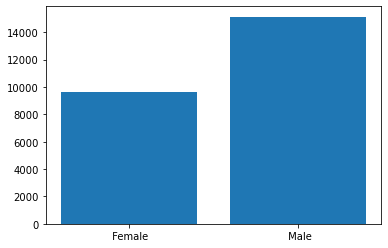

In [19]:
plot.bar(group_by_wage_class_sex['sex'], group_by_wage_class_sex['Total_count'])

The male contribution bit higher comapred to female for wages

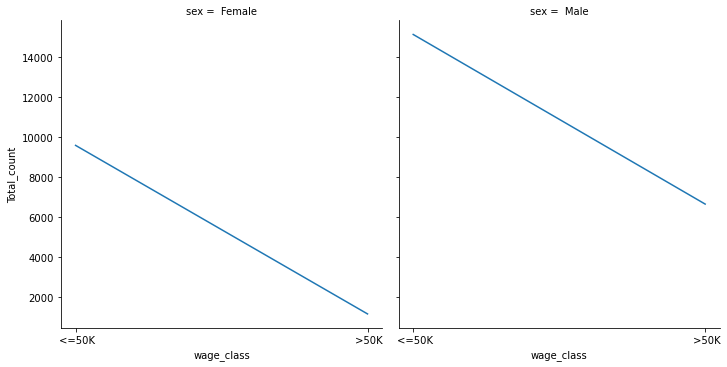

In [20]:
sns.relplot(data=group_by_wage_class_sex, x='wage_class', y='Total_count', col='sex', kind='line')

From the plot the Male is getting higher wages >50K & <=50K. 

In [21]:
country_wise_wages =  df_train.groupby(['native_country','wage_class'])['native_country'].count().to_frame(name = 'Total_count').reset_index()

In [22]:
country_lesser_50k = country_wise_wages[country_wise_wages['wage_class'].str.contains("<=50K")]

<BarContainer object of 42 artists>

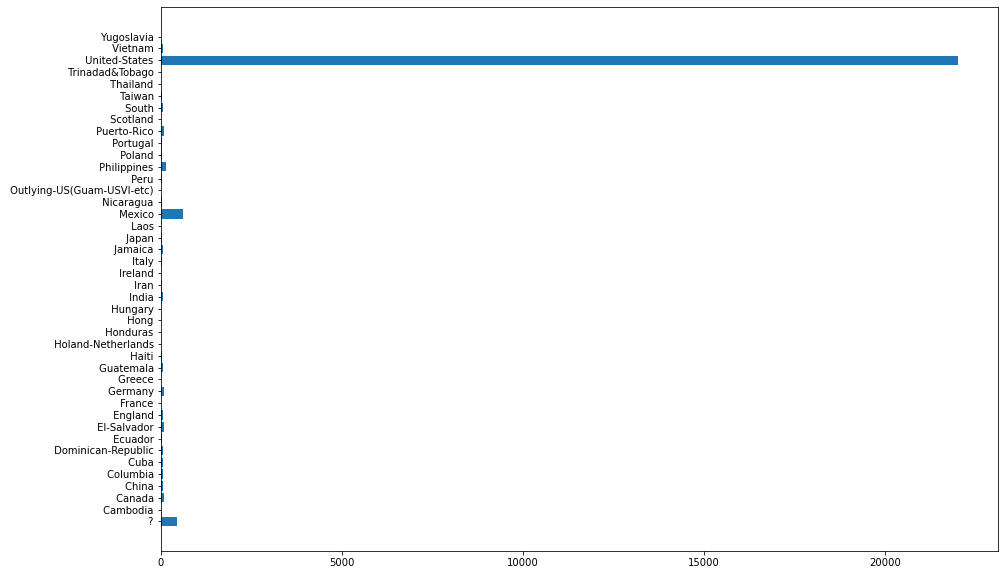

In [23]:
country = country_lesser_50k['native_country']
count = country_lesser_50k['Total_count']
 
# Figure Size
fig, ax = plot.subplots(figsize =(15, 10))
 
# Horizontal Bar Plot
ax.barh(country, count)

The country USA getting the most pay which is <=50K compariing to other countries

In [24]:
country_greater_50k = country_wise_wages[country_wise_wages['wage_class'].str.contains(">50K")]

<BarContainer object of 40 artists>

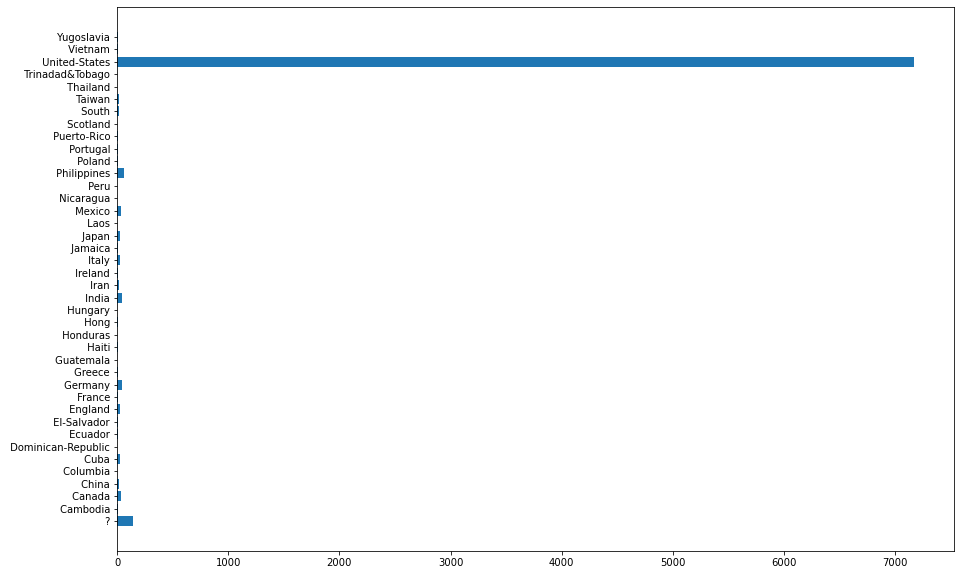

In [25]:
country = country_greater_50k['native_country']
count = country_greater_50k['Total_count']
 
# Figure Size
fig, ax = plot.subplots(figsize =(15, 10))
 
# Horizontal Bar Plot
ax.barh(country, count)

The country USA getting the most pay which is >50K compariing to other countries

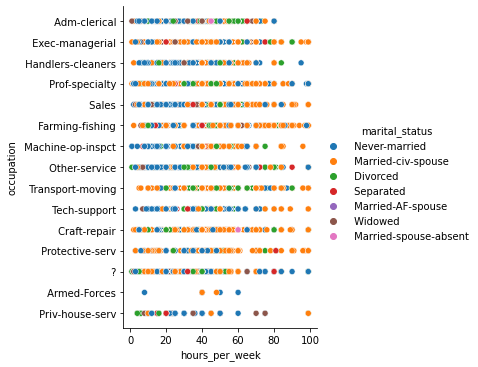

In [26]:
df_US = df_train[df_train['native_country'].str.contains('United-States')]
sns.relplot(data=df_US, y='occupation', x='hours_per_week', hue='marital_status')

For every US citizens plays a vital role and huge contribution to the wages. That confirms the US leads to first one.

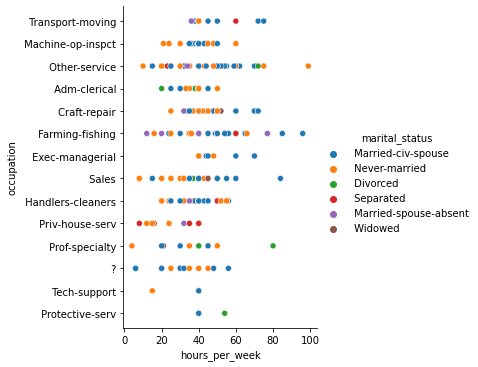

In [27]:
df_Mexico = df_train[df_train['native_country'].str.contains('Mexico')]
sns.relplot(data=df_Mexico, y='occupation', x='hours_per_week', hue='marital_status')

Well for Mexico, plays little bit on professional side comapring to US.

### For Testing data

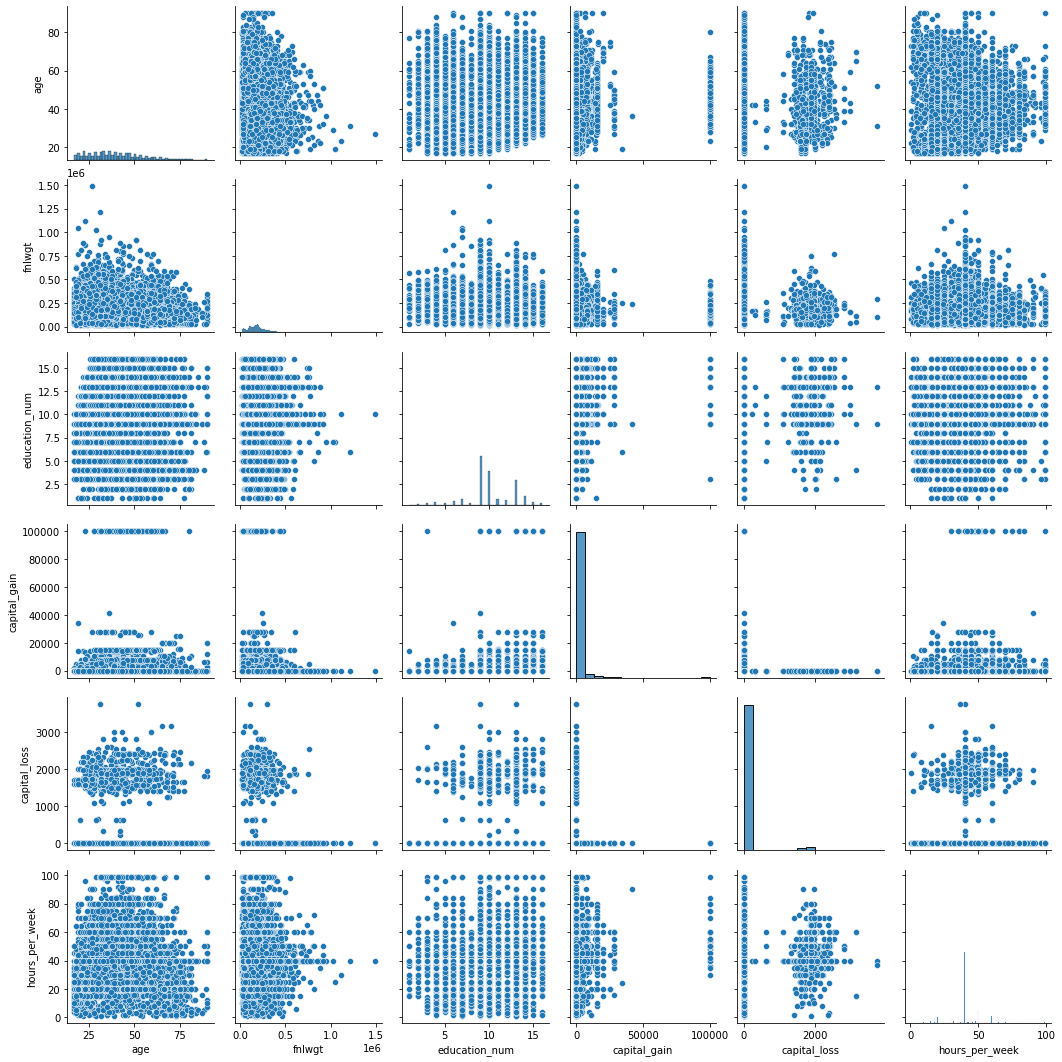

In [28]:
sns.pairplot(df_test)

In [29]:
group_by_wage_class_sex = df_test.groupby(['wage_class','sex'])['sex'].count().to_frame(name = 'Total_count').reset_index()
group_by_wage_class_count = group_by_wage_class_sex.groupby(['wage_class'])['Total_count'].sum()

([<matplotlib.patches.Wedge at 0x2574b6b1340>,
 [Text(-0.8107361809803564, 0.7434425632484241, '<=50K'),
  Text(0.8107362157834136, -0.7434425252951237, '>50K')],
 [Text(-0.44221973508019435, 0.40551412540823123, '76.38%'),
  Text(0.4422197540636801, -0.40551410470643107, '23.62%')])

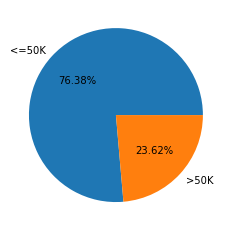

In [30]:
plot.pie(group_by_wage_class_count, autopct='%1.2f%%', labels=['<=50K','>50K'])

<BarContainer object of 4 artists>

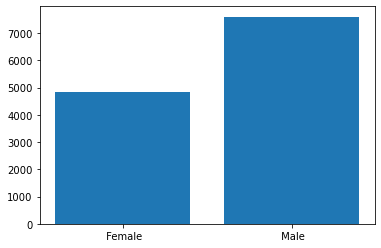

In [31]:
plot.bar(group_by_wage_class_sex['sex'], group_by_wage_class_sex['Total_count'])

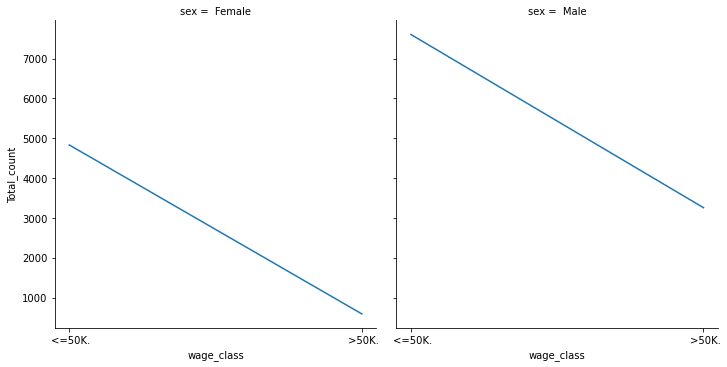

In [32]:
sns.relplot(data=group_by_wage_class_sex, x='wage_class', y='Total_count', col='sex', kind='line')

In [33]:
country_wise_wages =  df_test.groupby(['native_country','wage_class'])['native_country'].count().to_frame(name = 'Total_count').reset_index()
country_lesser_50k = country_wise_wages[country_wise_wages['wage_class'].str.contains("<=50K")]
country = country_lesser_50k['native_country']
count = country_lesser_50k['Total_count']


<BarContainer object of 41 artists>

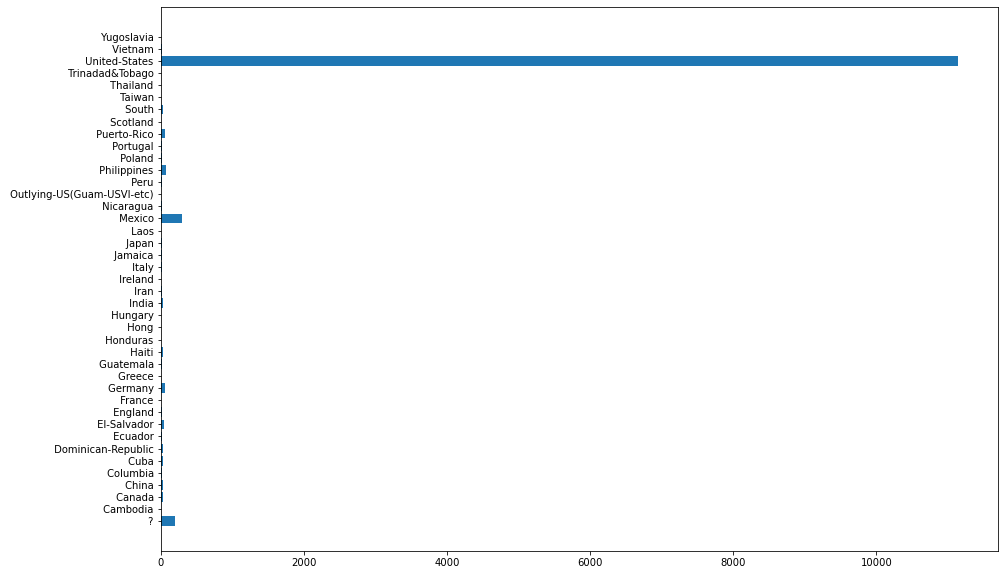

In [34]:
 
# Figure Size
fig, ax = plot.subplots(figsize =(15, 10))
 
# Horizontal Bar Plot
ax.barh(country, count)

<BarContainer object of 37 artists>

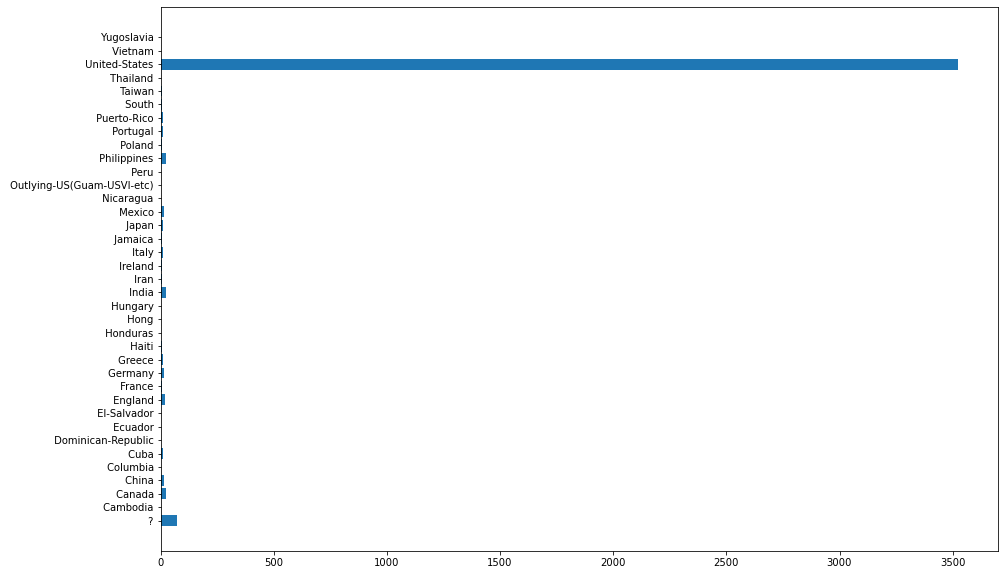

In [35]:

country_greater_50k = country_wise_wages[country_wise_wages['wage_class'].str.contains(">50K")]

country = country_greater_50k['native_country']
count = country_greater_50k['Total_count']
 
# Figure Size
fig, ax = plot.subplots(figsize =(15, 10))
 
# Horizontal Bar Plot
ax.barh(country, count)

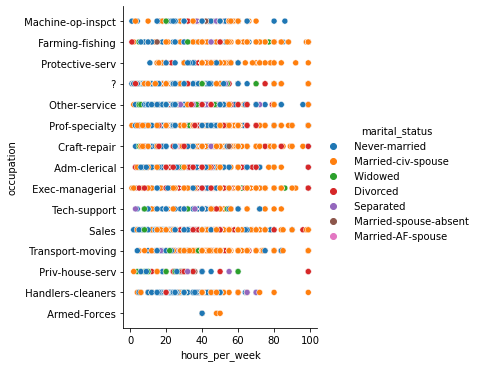

In [36]:
df_US = df_test[df_test['native_country'].str.contains('United-States')]
sns.relplot(data=df_US, y='occupation', x='hours_per_week', hue='marital_status')

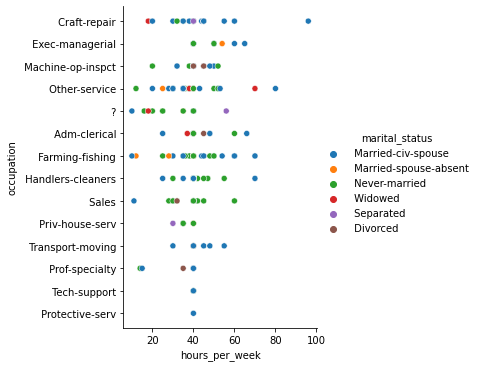

In [37]:
df_Mexico = df_test[df_test['native_country'].str.contains('Mexico')]
sns.relplot(data=df_Mexico, y='occupation', x='hours_per_week', hue='marital_status')

### Splitting the data to testing & training

In [38]:
train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


In [39]:
X_train= train.drop(columns = ['wage_class'], axis=1)
y_train = train['wage_class']

In [40]:
print(X_train.shape)
print(y_train.shape)

(32561, 14)
(32561,)


In [41]:
X_test = test.drop(columns=['wage_class'], axis=1)
y_test= test['wage_class']

In [42]:
print(X_test.shape)
print(y_test.shape)

(16281, 14)
(16281,)


In [43]:
model = XGBClassifier(n_estimators=20, max_depth=3,eta=0.5, gamma=2)
model.fit(X_train, y_train)

[10:40:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\ProgramFiles\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.5, gamma=2,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=20, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [44]:
train_pred = model.predict(X_train)
predictions = [round(value) for value in train_pred]
accuracy = accuracy_score(y_train,predictions)
accuracy

0.8679401738275851

In [45]:
test_pred = model.predict(X_test)
predictions = [round(value) for value in test_pred]
accuracy = accuracy_score(y_test,predictions)
accuracy

0.8691112339536884

The model predicts the accuracy about 86% accuracy. This looks good. Though model predicts good enough for the dataset.